In [1]:
using NBInclude
_PRECOMPILE_=false
_LC_ = true
@nbinclude("startup_GER.ipynb")

_tosave = true
suff = "ger_extd"


# from the calibration
germany = update_Country2(
  α= 0.24454461454611848,
  m= 0.10224779659110166,
  q0= 0.04010969167187745,
  qa= -1.8619387374624747e-5,
  λ1= 0.08184241763656157,
  λ0= 0.08184241763656157 + 0.022501141695896298)

C0 is Country2A(504.0, 456.0, 528.0, 780.0, 0.0048, NaN, NaN, NaN, NaN, NaN, NaN, 0.7, 0.68, 0.35, NaN, NaN, NaN)
Startup run in 29.950144052505493 secs.


Country2A(504.0, 456.0, 528.0, 780.0, 0.0048, 0.24454461454611848, 0.04010969167187745, -1.8619387374624747e-5, 0.10224779659110166, 0.08184241763656157, 0.10434355933245787, 0.7, 0.68, 0.35, 7.323615179959479e-7, 3.7271586815124338e-6, 3.6452215165258606e-5)

# 1) Simulation and plots
Plot the surplus.

Average cumulated nonemployment after 42 is 29.76811539850044in the model, and in the data 29.815890410958904


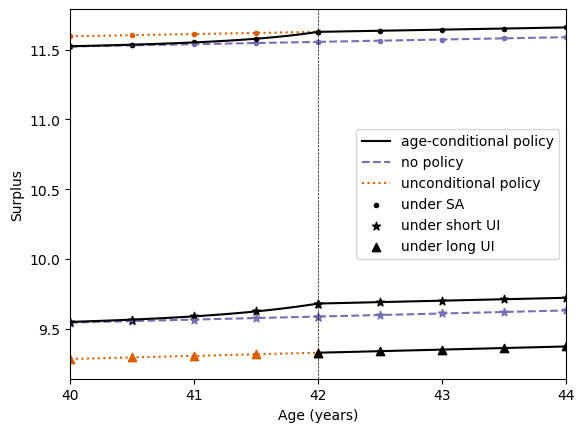

In [2]:
V = find_Surplus(germany)
println("Average cumulated nonemployment after 42 is ", average_U5(V, germany, Nind=100000), 
    "in the model, and in the data ",(892.9+28/2)/365*12)  
plot_surplus(V, germany, xlim=(40,44), xtic=40:44, markevery=6, loc=5)
_tosave ? savefig(joinpath(dir_graph,"surplus_$suff.png")) : ()

Plot the job-finding rates.

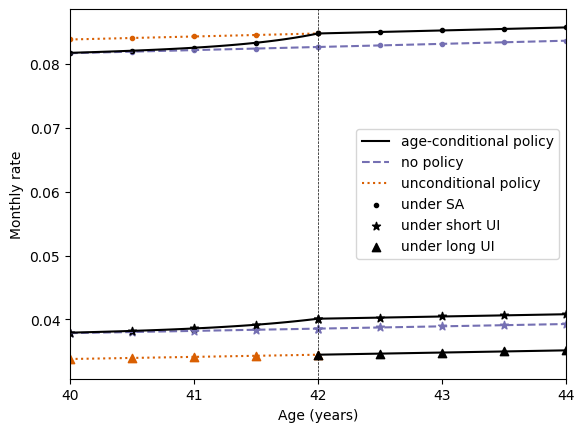

In [3]:
plot_JFR(V, germany, xlim=(40,44), xtic=40:44, markevery=6, loc=5)
_tosave ? savefig(joinpath(dir_graph,"jfr_$suff.png")) : ()

Plot the distribution of nonemployed workers.

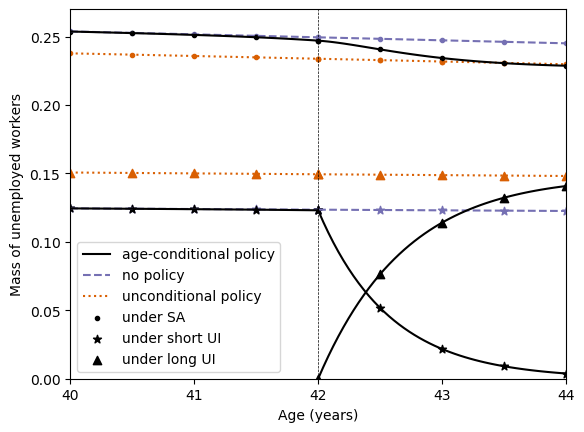

In [4]:
unemp = find_Unemp(V, germany) 
plot_unemp(unemp, germany, xlim=(40,44), xtic=40:44, markevery=6, ylim=(0,0.27), loc=3)
_tosave ? savefig(joinpath(dir_graph,"unemp_$suff.png")) : ()

Plot the dynamics of unemployment.

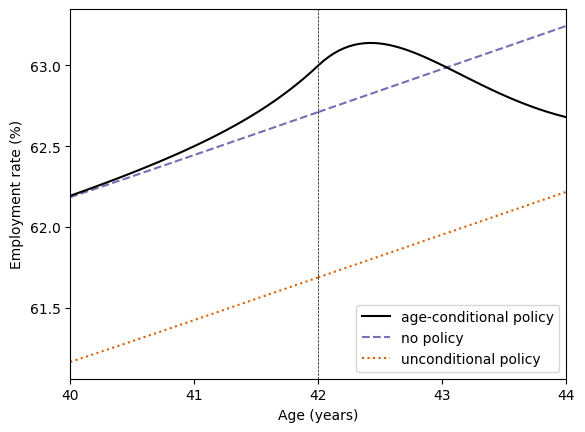

In [5]:
plot_emp(unemp, germany, xlim=(40,44), xtic=40:44, ytic=61.5:0.5:63, loc=4) 
_tosave ? savefig(joinpath(dir_graph,"emp_$suff.png")) : ()

Plot the average UI duration by age. 

The graphical LATE is 1.5918830803802644
The RDD estimand is 1.6664242597329721
The RDD bias corresponds to a share of the LATE: 0.04682578781784752


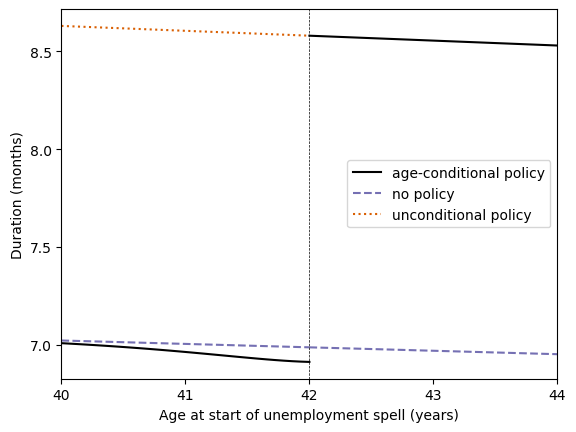

In [6]:
plot_expectedB(V, germany, xlim=(40,44), xtic=40:44, ytic=7:0.5:8.5, loc=5) 
_tosave ? savefig(joinpath(dir_graph,"UIdur_$suff.png")) : ()

## add annotation
expB_without = expectedB_without(germany.A, V, germany)
expB_with = expectedB_with(germany.A, V, germany)
LATE = expB_with-expB_without
println("The graphical LATE is $LATE")
expB_aft = expectedB(germany.A, V, germany)
expB_bef = expectedB(germany.A-0.001, V, germany)
RDDand = expB_aft-expB_bef
println("The RDD estimand is $RDDand")
println("The RDD bias corresponds to a share of the LATE: ", (RDDand-LATE)/LATE)

Plot the average nonemployment duration by age.

The graphical LATE is 1.0584358119667492
The RDD estimand is 1.4359409748129401
The RDD bias corresponds to a share of the LATE: 0.356663255889579


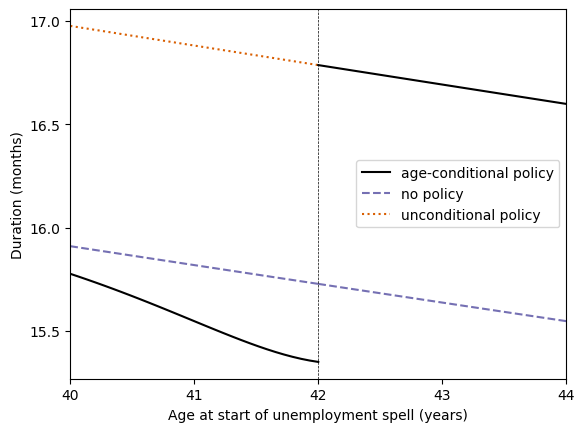

In [7]:
plot_expectedD(V, germany, xlim=(40,44), xtic=40:44, ytic=15.5:0.5:17, loc=5) 
_tosave ? savefig(joinpath(dir_graph,"NEdur_$suff.png")) : ()


expD_without = expectedD_without(germany.A, V, germany)
expD_with = expectedD_with(germany.A, V, germany)
LATE = expD_with-expD_without
println("The graphical LATE is $LATE")
expD_aft = expectedD(germany.A, V, germany)
expD_bef = expectedD(germany.A-0.001, V, germany)
RDDand = expD_aft-expD_bef
println("The RDD estimand is $RDDand")
println("The RDD bias corresponds to a share of the LATE: ", (RDDand-LATE)/LATE)

Plot the fit.

We print the targeted and simulated moments:


1×2 Matrix{Float64}:
 29.8159  29.7681

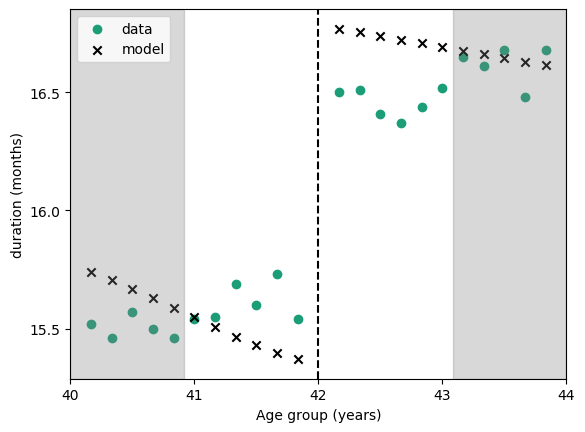

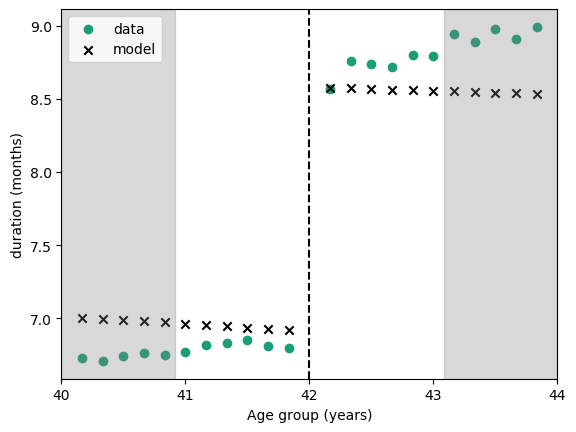

In [8]:
moments_model_all= moments_germany_UI(V,germany, a_range=data_ger_NE.age)
  
println("We print the targeted and simulated moments:")
display(hcat(moments_target_UI[3], moments_model_all[3]))

plot_fit(data_ger_NE, moments_model_all[2], germany, 
    xlim=(40,44),  xtic=40:44, xshades=(41-1/12, 43+1/12), 
    ytic=15.5:0.5:16.5, ylab="duration (months)")
_tosave ? savefig(joinpath(dir_graph,"fitNE_$suff.png")) : ()

plot_fit(data_ger_UI, moments_model_all[1], germany, 
    xlim=(40,44),  xtic=40:44, xshades=(41-1/12, 43+1/12), 
    ylab="duration (months)")
_tosave ? savefig(joinpath(dir_graph,"fitUI_$suff.png")) : ()

# 2) RDD with simulated model
We generate the simulated data points. We define $Y_a$ as the average nonemployment duration at age $a$ in months. 

In [9]:
@time let 
freq = 1/12 # 1 for yearly, 1/12 for monthly, 1/365 for daily, do not change with daily freq
age_grid0 = ( 40:freq:44 ) *12
Y = [expectedD(m,V,germany) for m in age_grid0]
    
table = zeros(7)

#explaining variables
TREAT = age_grid0 .>= germany.A
consta = ones(size(age_grid0))
age1 = collect(age_grid0)
age2 = age1 .^2
age3 = age1 .^3
age1_spl = (age1 .- germany.A) .* TREAT 
age2_spl = (age1 .- germany.A).^2 .* TREAT 
age3_spl = (age1 .- germany.A).^3 .* TREAT 

## no trend
X = hcat(TREAT, consta)
beta = inv(X' * X) * (X' * Y)
table[1] = beta[1] 

## linear spline
X = hcat(TREAT, consta, age1, age1_spl)
beta = inv(X' * X) * (X' * Y)
table[2] = beta[1]

## cubic spline
X = hcat(TREAT, consta, age1, age1_spl, age2, age2_spl, age3, age3_spl)
beta = inv(X' * X) * (X' * Y)
table[3] = beta[1]
    
## with different bandwidths
for (i,band) in enumerate([2.,1.,0.5,0.2] *12)

    myindexes = germany.A - band .<= age_grid0 .<= germany.A + band
    age_grid = age_grid0[myindexes]
    newY = Y[myindexes]
    
    #explaining variables
    TREAT = age_grid .>= germany.A
    consta = ones(size(age_grid))
    age1 = collect(age_grid)
    age1_spl = (age1 .- germany.A) .* TREAT 

    ## linear spline
    X = hcat(TREAT, consta, age1, age1_spl )   
    beta = inv(X' * X) * (X' * newY)
    table[3+i] = beta[1] 
end    
    
## RDD estimates from the data on the left
display(hcat([0,0,0,0.78, 0.92, 1.04, 0.79] ,table))
end

7×2 Matrix{Float64}:
 0.0   1.13232
 0.0   1.46438
 0.0   1.44071
 0.78  1.46438
 0.92  1.45598
 1.04  1.44481
 0.79  1.43827

  7.628425 seconds (71.48 M allocations: 5.855 GiB, 18.74% gc time, 46.59% compilation time)
